In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")


In [3]:
df = pd.read_csv("/Users/vibhutihardoneeya/Desktop/internshala_internships.csv")

print("--- First 5 Rows ---")
display(df.head())

print("\n--- Dataset Info ---")
df.info()

print("\n--- Missing Values ---")
print(df.isnull().sum())


--- First 5 Rows ---


,Title,Company,Location,Duration,Stipend,Posted_Date,Link
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fundraising Volunteer,Odisha Development Management Programme (ODMP),Work from home,1 Week,"₹ 500 - 5,000 /week",6 days ago,https://internshala.com/internship/detail/work...
2,Business Development (Sales),Creative Mediapulse Technologies Private Limit...,Work from home,6 Months,"₹ 5,500 - 10,000 /month",4 days ago,https://internshala.com/internship/detail/work...
3,Web Development,Kanha Creation,Work from home,1 Month,"₹ 5,000 /month",6 days ago,https://internshala.com/internship/detail/work...
4,Trading,Focus Wise Solution,Work from home,1 Month,"₹ 1,800 - 2,500 /month",1 week ago,https://internshala.com/internship/detail/work...



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        80 non-null     object
 1   Company      80 non-null     object
 2   Location     80 non-null     object
 3   Duration     80 non-null     object
 4   Stipend      80 non-null     object
 5   Posted_Date  80 non-null     object
 6   Link         80 non-null     object
dtypes: object(7)
memory usage: 4.7+ KB

--- Missing Values ---
Title          4
Company        4
Location       4
Duration       4
Stipend        4
Posted_Date    4
Link           4
dtype: int64


In [5]:
def clean_stipend(stipend):
    stipend_str = str(stipend).lower()
    if 'unpaid' in stipend_str:
        return 0
    cleaned_str = re.sub(r'[₹,]', '', stipend_str)
    numbers = [int(s) for s in re.findall(r'\d+', cleaned_str)]
    if not numbers:
        return np.nan
    avg_stipend = sum(numbers) / len(numbers)
    if 'week' in stipend_str:
        return avg_stipend * 4
    if 'lump sum' in stipend_str:
        return avg_stipend / 2
    return avg_stipend

def clean_duration(duration):
    duration_str = str(duration).lower()
    numbers = [int(s) for s in re.findall(r'\d+', duration_str)]
    if not numbers:
        return np.nan
    num = numbers[0]
    if 'week' in duration_str:
        return num / 4.0
    return float(num)

def categorize_title(title):
    title_lower = str(title).lower()
    if any(keyword in title_lower for keyword in ['data science', 'data analytics', 'machine learning', 'ai', 'analyst']):
        return 'Data Science & AI'
    if any(keyword in title_lower for keyword in ['web development', 'front end', 'backend', 'flutter', 'android', 'php']):
        return 'Web & App Development'
    if any(keyword in title_lower for keyword in ['marketing', 'sales', 'business development', 'seo']):
        return 'Marketing & Sales'
    if any(keyword in title_lower for keyword in ['graphic design', 'ui/ux']):
        return 'Design'
    if any(keyword in title_lower for keyword in ['hr', 'human resources']):
        return 'Human Resources'
    if 'content writing' in title_lower:
        return 'Content Writing'
    return 'Other'

In [7]:
df.dropna(subset=['Title'], inplace=True)

df['Monthly_Stipend_INR'] = df['Stipend'].apply(clean_stipend)
df['Duration_in_Months'] = df['Duration'].apply(clean_duration)
df['Category'] = df['Title'].apply(categorize_title)

df.dropna(subset=['Monthly_Stipend_INR', 'Duration_in_Months'], inplace=True)

print("--- Cleaned and Engineered Data Sample ---")
display(df[['Title', 'Category', 'Monthly_Stipend_INR', 'Duration_in_Months']].head())


--- Cleaned and Engineered Data Sample ---


,Title,Category,Monthly_Stipend_INR,Duration_in_Months
1,Fundraising Volunteer,Data Science & AI,11000.0,0.25
2,Business Development (Sales),Marketing & Sales,7750.0,6.00
3,Web Development,Web & App Development,5000.0,1.00
4,Trading,Other,2150.0,1.00
5,Financial Analyst,Data Science & AI,1750.0,1.00


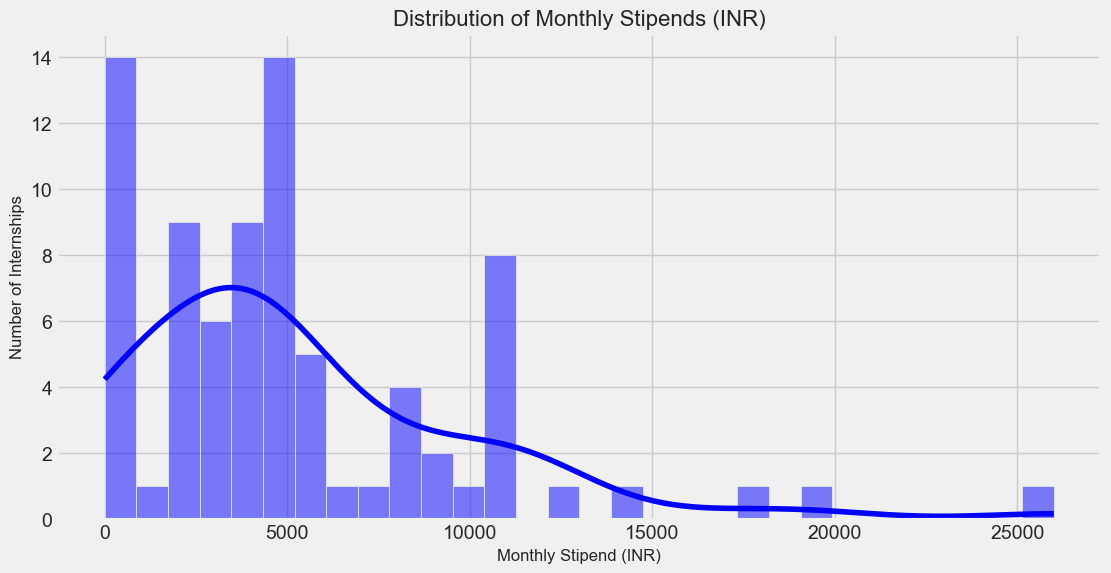

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Monthly_Stipend_INR'], bins=30, kde=True, color='blue')
plt.title('Distribution of Monthly Stipends (INR)', fontsize=16)
plt.xlabel('Monthly Stipend (INR)', fontsize=12)
plt.ylabel('Number of Internships', fontsize=12)
plt.show()


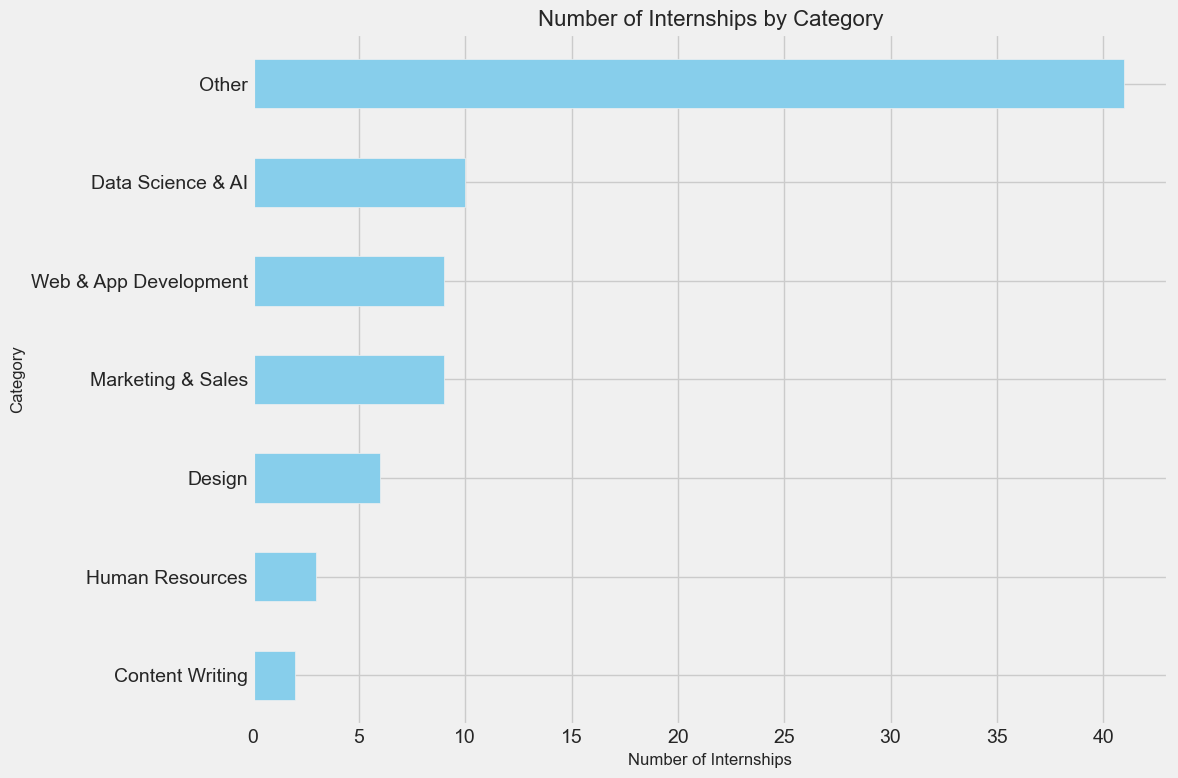

In [9]:
plt.figure(figsize=(12, 8))
df['Category'].value_counts().sort_values().plot(kind='barh', color='skyblue')
plt.title('Number of Internships by Category', fontsize=16)
plt.xlabel('Number of Internships', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/41/t3bg1wbx2m7b8lhbcdtt0ljm0000gn/T/ipykernel_27537/862106029.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Monthly_Stipend_INR', y='Category', order=sorted_order, palette='viridis')


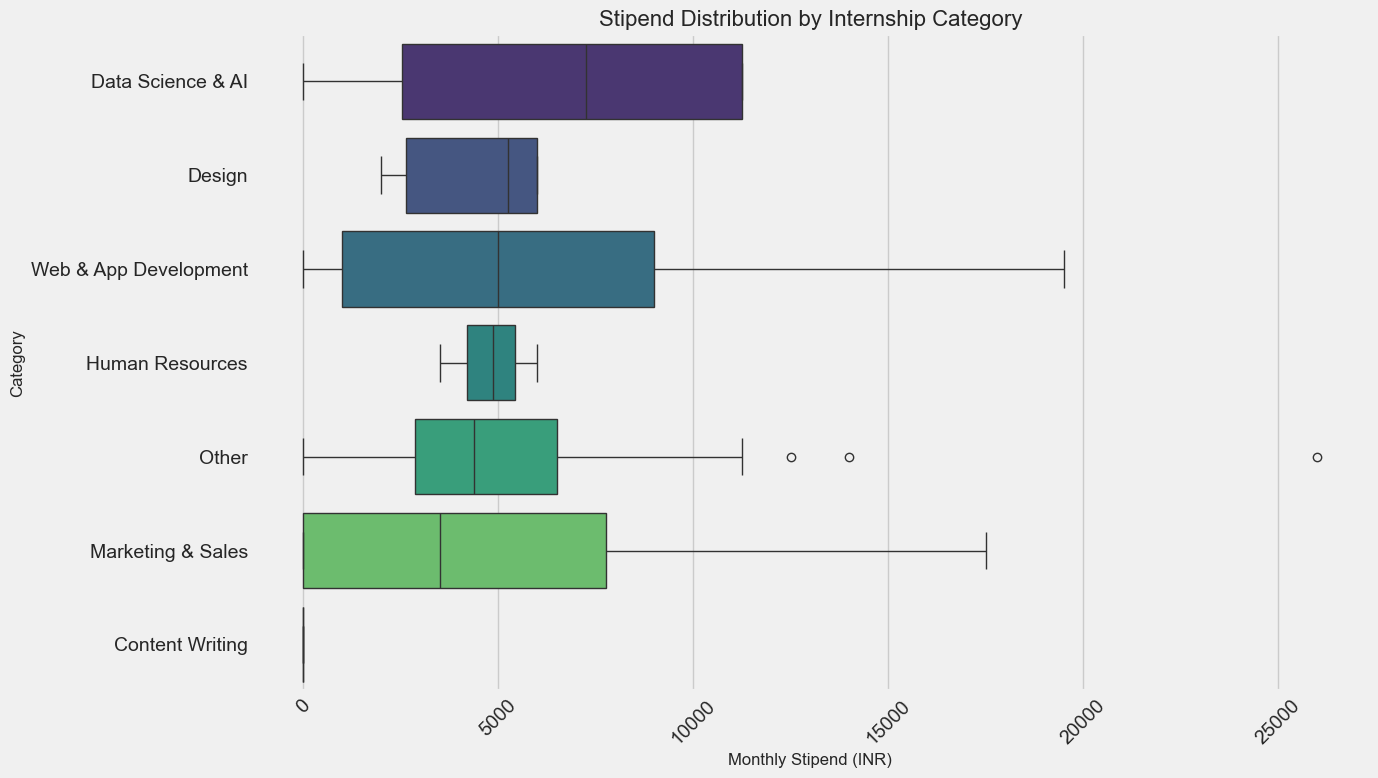

In [10]:
plt.figure(figsize=(14, 8))

sorted_order = df.groupby('Category')['Monthly_Stipend_INR'].median().sort_values(ascending=False).index

sns.boxplot(data=df, x='Monthly_Stipend_INR', y='Category', order=sorted_order, palette='viridis')
plt.title('Stipend Distribution by Internship Category', fontsize=16)
plt.xlabel('Monthly Stipend (INR)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
features = ['Category', 'Duration_in_Months']
target = 'Monthly_Stipend_INR'

X = df[features]
y = df[target]

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['Category'])],
    remainder='passthrough')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("--- Model Performance ---")
print(f"Root Mean Squared Error (RMSE): ₹{rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

if r2 > 0.5:
    print(f"\nThe R² value indicates that the model explains approximately {r2:.0%} of the variance in stipends, which is a good fit.")
else:
    print(f"\nThe R² value is low, indicating that 'Category' and 'Duration' alone are not strong predictors of the stipend.")


--- Model Performance ---
Root Mean Squared Error (RMSE): ₹6976.27
R-squared (R²): -0.02

The R² value is low, indicating that 'Category' and 'Duration' alone are not strong predictors of the stipend.


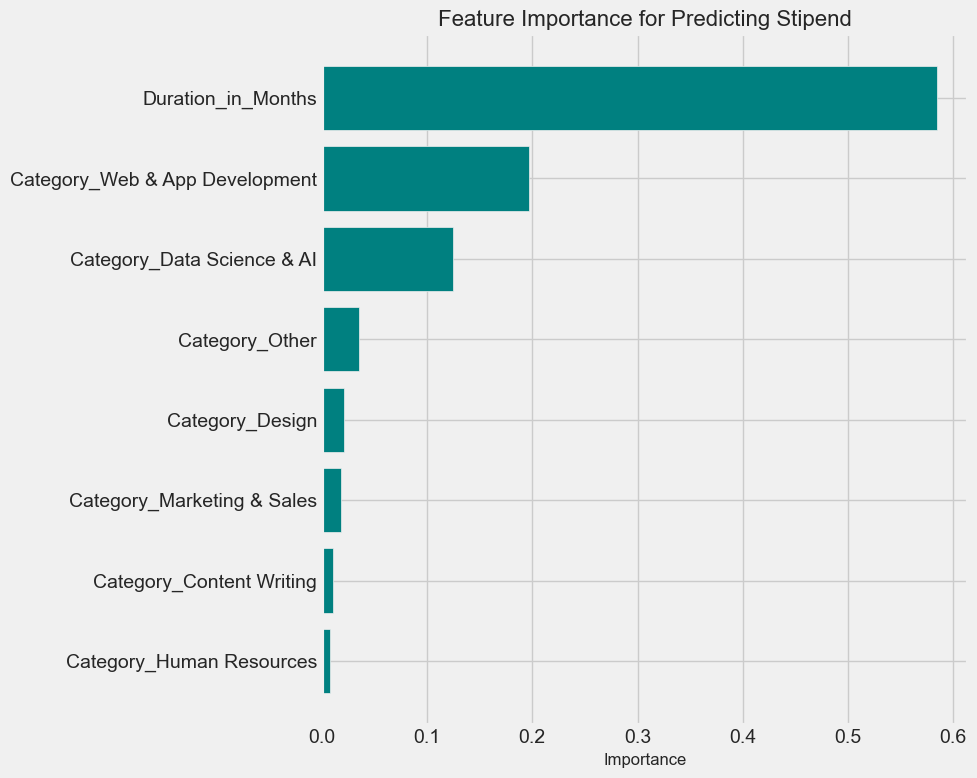

In [13]:
try:
    ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['Category'])
    all_feature_names = np.append(ohe_feature_names, ['Duration_in_Months'])

    importances = model.named_steps['regressor'].feature_importances_

    feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
    plt.title('Feature Importance for Predicting Stipend', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate feature importance plot. Error: {e}")
